In [1]:
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

import numpy as np
from os.path import join
import os

Using TensorFlow backend.


In [2]:
region = 'curated'
roof_dir = join('..', '..', 'sample', region, 'roofs')
materials = {'healthy_metal':0, 'irregular_metal':1, 'concrete_cement':2, 'incomplete':3, 'other':4}

### Calculate features

This uses a pretrained network to compute features from the images, which are later classified.
First, load the model, from which we remove the top layer

In [3]:
model = ResNet50(weights='imagenet', include_top=False, pooling='max')
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
___________________________________________________________________________________________

Traverse all images in their corresponding folders which indicate the material and use `model.predict()` to get the features.

In [4]:
# Count the number of images
nof_roofs = 0;
for material in materials.keys():
    material_fp = join(roof_dir, material)
    nof_this = len([name for name in os.listdir(material_fp) if os.path.isfile(join(material_fp, name))])
    print(nof_this)
    nof_roofs = nof_roofs + nof_this
#print(nof_roofs)

labels = []
resnet50_feature_matrix = np.zeros((nof_roofs, 2048), dtype=float)

# Walk through all images
i = 0;
for material in materials.keys():
    material_fp = join(roof_dir, material)
    for root, dirs, files in os.walk(material_fp):
        for file in files:
            img_fp = join(material_fp, file)
            label = materials[material]
            labels.append(label)
            print(img_fp, "labeled as ", material, ":", label)
    
            img = image.load_img(img_fp, target_size=(224, 224))
            img_data = image.img_to_array(img)
            img_data = np.expand_dims(img_data, axis=0)
            img_data = preprocess_input(img_data)
            
            resnet50_feature = model.predict(img_data)
            resnet50_feature_np = np.array(resnet50_feature)
            resnet50_feature_matrix[i] = resnet50_feature_np.flatten()
            i = i + 1

51
25
19
0
0
..\..\sample\curated\roofs\healthy_metal\7a1ea402.tif labeled as  healthy_metal : 0
..\..\sample\curated\roofs\healthy_metal\7a1ec590.tif labeled as  healthy_metal : 0
..\..\sample\curated\roofs\healthy_metal\7a1f387c.tif labeled as  healthy_metal : 0
..\..\sample\curated\roofs\healthy_metal\7a1f5d2a.tif labeled as  healthy_metal : 0
..\..\sample\curated\roofs\healthy_metal\7a1fb914.tif labeled as  healthy_metal : 0
..\..\sample\curated\roofs\healthy_metal\7a206832.tif labeled as  healthy_metal : 0
..\..\sample\curated\roofs\healthy_metal\7a2176f0.tif labeled as  healthy_metal : 0
..\..\sample\curated\roofs\healthy_metal\7a2246c0.tif labeled as  healthy_metal : 0
..\..\sample\curated\roofs\healthy_metal\7a237ca2.tif labeled as  healthy_metal : 0
..\..\sample\curated\roofs\healthy_metal\7a239db8.tif labeled as  healthy_metal : 0
..\..\sample\curated\roofs\healthy_metal\7a243732.tif labeled as  healthy_metal : 0
..\..\sample\curated\roofs\healthy_metal\7a24afdc.tif labeled a

In [5]:
unique, index, count = np.unique(resnet50_feature_matrix,
                                 axis = 0,
                                 return_index=True,
                                 return_counts=True)

In [6]:
index.sort()
print(index)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]


In [11]:
import pickle
pickle_path = '.'
with open(join(pickle_path, 'resnet50_feature_matrix_' + region + '.pkl' ), 'wb') as f:
    pickle.dump(resnet50_feature_matrix, f)
with open(join(pickle_path, 'labels_' + region + '.pkl' ), 'wb') as f:
    pickle.dump(np.asarray(labels), f)

### Visualize the features

Reduce the dimensionality to 2D using tSNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
%matplotlib inline

In [9]:
def plot_tSNE(features, labels=None, number_of_materials=5):
    if labels is None:
        labels = np.zeros((features.shape[0]))

    # Visualization_
    #pca_object = PCA(n_components=50)
    #pca_features = pca_object.fit_transform(features)
    tsne_features = TSNE(n_components=2).fit_transform(features)

    # define the colormap
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    bounds = np.linspace(0, number_of_materials, number_of_materials + 1)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    
    print(tsne_features.shape)
    
    # Plot D-Vectors
    plt.figure()
    scat = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap=cmap, norm=norm)
    cb = plt.colorbar(scat, spacing='proportional', ticks=bounds)

(95, 2)


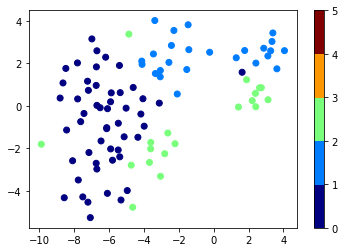

In [10]:
plot_tSNE(resnet50_feature_matrix, labels)